# 1 QAOA with PennyLane

We use Quantum Approximate Optimization Algorithm. We start with a fully mixed state and move towards Ising-like Hamiltonian.


* [Intro to QAOA by Xanadu](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html)
* [A Quantum Approximate Optimization Algorithm, arXiv:1411.4028](https://arxiv.org/abs/1411.4028)
* [From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz, arXiv:1709.03489
](https://arxiv.org/abs/1709.03489)
* [Max Independent Set and Quantum Alternating Operator Ansatz, arXiv:1905.04809
](https://arxiv.org/abs/1905.04809)

## TODO

* Encode more than 2 tile values.

In [1]:
import numpy as np
import pennylane as qml
from pennylane import qaoa
from livelossplot import PlotLosses

## Board

Setting board size and mapping from position to qubits.

In [2]:
width = 4
height = 3
total_tiles = width * height

# turn position into a qubit id
def xy2qubit(x, y):
    return x * height + y

for x in range(width):
    for y in range(height):
        print(f"({x}, {y}) -> {xy2qubit(x, y)}")

(0, 0) -> 0
(0, 1) -> 1
(0, 2) -> 2
(1, 0) -> 3
(1, 1) -> 4
(1, 2) -> 5
(2, 0) -> 6
(2, 1) -> 7
(2, 2) -> 8
(3, 0) -> 9
(3, 1) -> 10
(3, 2) -> 11


## Hamiltonians

### Mixer Hamiltonian

In [3]:
# we use a typical mixing Hamiltonian flipping all qubits separately
h_mixer = qml.Hamiltonian(
    [1] * total_tiles,
    [qml.PauliX(i) for i in range(total_tiles)]
)

print(h_mixer)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]
+ (1) [X8]
+ (1) [X9]
+ (1) [X10]
+ (1) [X11]


### Cost Hamiltonian

We need to encode energy (cost, or when dealing with probabilities: negative log-likelihood):

* b00 energy of neighbors with same tile id 0
* b11 energy of neighbors with same tile id 1
* b01 = a10 energy for neighbors with different tile ids (i.e 0 and 1)

Classically, for two spins (s and t) our energy would be an expeciation value

$$\vec{s}^T \begin{bmatrix} b_{00} &  b_{01} \\ b_{10} &  b_{11} \end{bmatrix} \vec{t} $$

Here we need to find a two-body Hamiltonian. It is:

$$ b_{00} |00 \rangle \langle 00 | + b_{01} |01 \rangle \langle 01 | + b_{10} |10 \rangle \langle 10 | + b_{11} |11 \rangle \langle 11 |$$

We can expand that ($b_{01} = b_{10}$ to save us time)

$$
\begin{bmatrix}
  b_{00} & 0 & 0 & 0 \\
  0 & b_{01} & 0 & 0 \\
  0 & 0 & b_{01} & 0 \\
  0 & 0 & 0 & b_{11}
\end{bmatrix} 
= \frac{b_{00} + b_{11} + 2 b_{01}}{4} I \otimes I + \frac{b_{00} - b_{11}}{4} (I \otimes Z + Z \otimes I) + \frac{b_{00} + b_{11} - 2 b_{01}}{4} Z \otimes Z
$$

Since we don't care about the absolute energy, we drop the idenity term, so

$$
H_c = \frac{b_{00} - b_{11}}{4} (I \otimes Z + Z \otimes I)  + \frac{b_{00} + b_{11} - 2 b_{01}}{4} Z \otimes Z
$$

Summation goes thorugh each edge (conenction between tiles), so that each tile gets as many Z as many edges it has. For a square grid, it is:

* 4 in the center,
* 3 on the board boundary,
* 2 in the corner.

Boundary conditions are pesky in general (fixed, open, wrapped, anything), so for the sake of this problem we simply it by giving 4 always.

In [4]:
# we can generate it form data or hand-pick it
b00 = 0.5
# b01 = 0.1  # kind of a normal value
b01 = -3. # antiferromagnetic = checkerboard!
# b01 = 3.  # ferromagnetic = all the same
b11 = 0.5

coeff_z = b00 - b11
coeff_zz = (b00 + b11 - 2 * b01) / 4

In [5]:
h_one = qml.Hamiltonian(
    [coeff_z] * total_tiles,
    [qml.PauliZ(i) for i in range(total_tiles)]
)

In [6]:
zz_ops_h = []
for x in range(width - 1):
    for y in range(height):
        i = xy2qubit(x, y)
        j = xy2qubit(x + 1, y)
        zz_ops_h.append(qml.PauliZ(i) @ qml.PauliZ(j))

zz_ops_v = []
for x in range(width):
    for y in range(height - 1):
        i = xy2qubit(x, y)
        j = xy2qubit(x, y + 1)
        zz_ops_h.append(qml.PauliZ(i) @ qml.PauliZ(j))
        

In [7]:
n_edges = 2 * width * height - width - height
n_edges

17

In [8]:
h_two = qml.Hamiltonian(
    [coeff_zz] * n_edges,
    zz_ops_h + zz_ops_v
)

In [9]:
h_cost = h_one + h_two
print(h_cost)

  (0.0) [Z0]
+ (0.0) [Z1]
+ (0.0) [Z2]
+ (0.0) [Z3]
+ (0.0) [Z4]
+ (0.0) [Z5]
+ (0.0) [Z6]
+ (0.0) [Z7]
+ (0.0) [Z8]
+ (0.0) [Z9]
+ (0.0) [Z10]
+ (0.0) [Z11]
+ (1.75) [Z0 Z3]
+ (1.75) [Z1 Z4]
+ (1.75) [Z2 Z5]
+ (1.75) [Z3 Z6]
+ (1.75) [Z4 Z7]
+ (1.75) [Z5 Z8]
+ (1.75) [Z6 Z9]
+ (1.75) [Z7 Z10]
+ (1.75) [Z8 Z11]
+ (1.75) [Z0 Z1]
+ (1.75) [Z1 Z2]
+ (1.75) [Z3 Z4]
+ (1.75) [Z4 Z5]
+ (1.75) [Z6 Z7]
+ (1.75) [Z7 Z8]
+ (1.75) [Z9 Z10]
+ (1.75) [Z10 Z11]


## Creating circuit


In [10]:
dev = qml.device('default.qubit', wires=range(total_tiles))

# a single layer
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, h_cost)
    qaoa.mixer_layer(alpha, h_mixer)

# number of layers
depth = 4
    

# circuit
def circuit(params, **kwargs):
    qml.layer(qaoa_layer, depth, params[0], params[1])

cost_func = qml.ExpvalCost(circuit, h_cost, dev) 

## Classical optimization

Warning: classical, dense, and will eat memory easily if left to its own devices.

Even a grid of 3x4 requires a vector of 10^12 = 4096 coordinates.

We use the new, cool `qml.QNGOptimizer` [Quantum natural gradient](https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html) instead of old, boring stochastic gradient descent.

EDIT: We want to use the new one, but it gives an error. :(

For plotting we use [livelossplot](https://github.com/stared/livelossplot). It is a Python package for tracking training of deep learning models... but why not use it for quantum optimization!

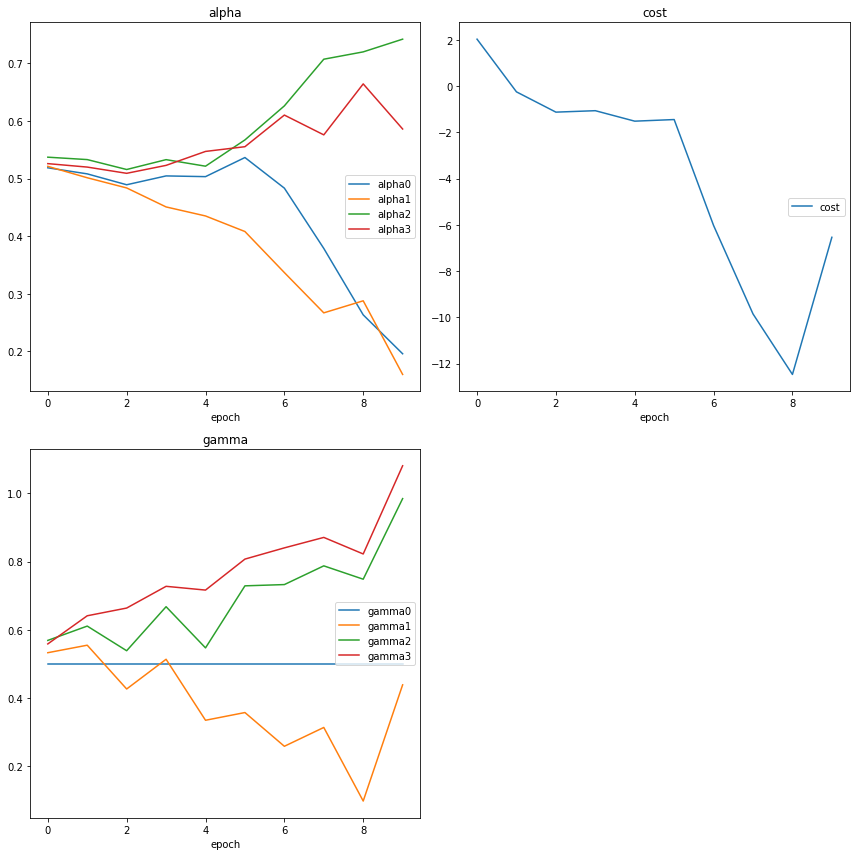

alpha
	alpha0           	 (min:    0.196, max:    0.537, cur:    0.196)
	alpha1           	 (min:    0.160, max:    0.521, cur:    0.160)
	alpha2           	 (min:    0.516, max:    0.742, cur:    0.742)
	alpha3           	 (min:    0.509, max:    0.665, cur:    0.586)
cost
	cost             	 (min:  -12.465, max:    2.025, cur:   -6.538)
gamma
	gamma0           	 (min:    0.500, max:    0.500, cur:    0.500)
	gamma1           	 (min:    0.098, max:    0.555, cur:    0.439)
	gamma2           	 (min:    0.539, max:    0.985, cur:    0.985)
	gamma3           	 (min:    0.559, max:    1.081, cur:    1.081)


In [11]:
# gammas and alphas for each layer - initial values
init_gamma_alpha = 0.5 * np.ones((2, depth))

opt = qml.GradientDescentOptimizer(stepsize=0.005)  # 0.4 was WAY too much  
# opt = qml.QNGOptimizer(0.01)
n_iterations = 10
gamma_alpha = init_gamma_alpha


livelossplot_groups = {
    'cost': ['cost'],
    'gamma': ['gamma0', 'gamma1', 'gamma2', 'gamma3'],
    'alpha': ['alpha0', 'alpha1', 'alpha2', 'alpha3']
}
plotlosses = PlotLosses(groups=livelossplot_groups)
for i in range(n_iterations):
    gamma_alpha, cost = opt.step_and_cost(cost_func, gamma_alpha)
    plotlosses.update({
        'cost': cost,
        'gamma0': gamma_alpha[0, 0],
        'gamma1': gamma_alpha[0, 1],
        'gamma2': gamma_alpha[0, 2],
        'gamma3': gamma_alpha[0, 3],
        'alpha0': gamma_alpha[1, 0],
        'alpha1': gamma_alpha[1, 1],
        'alpha2': gamma_alpha[1, 2],
        'alpha3': gamma_alpha[1, 3],
    })
    plotlosses.send()

In [12]:
gamma_alpha

tensor([[0.5       , 0.4387925 , 0.98490704, 1.08121148],
        [0.19596039, 0.16008696, 0.74217279, 0.58619355]], requires_grad=True)

In [13]:
@qml.qnode(dev)
def probability(p):
    circuit(p)
    return qml.probs(wires=dev.wires)

probs = probability(gamma_alpha)

In [14]:
probs.size

4096

In [15]:
np.argmax(probs)

2709

In [16]:
optimal_seq = np.binary_repr(np.argmax(probs), total_tiles)
optimal_seq

'101010010101'

In [17]:
np.array([int(s) for s in optimal_seq]).reshape(width, height)

array([[1, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 1]])

In [ ]:
# No sure if this almost-checkerboard is because of the boundary condition or optimization

## Sampling

Right now it does not work and I don't uderstand API. :(

In [ ]:
dev2 = qml.device("default.qubit", wires=total_tiles, shots=5)

@qml.qnode(dev2)
def circuit(params, **kwargs):
    qml.layer(qaoa_layer, depth, params[0], params[1])
    return qml.sample(qml.PauliZ(0))
    # return qml.sample(h_cost)

In [ ]:
circuit(alphas_gammas)